In [1]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import rdRGroupDecomposition
from rdkit.Chem import rdDepictor
import rdkit
import pandas as pd
import numpy as np
from rdkit.Chem import PandasTools
import time
print(rdkit.__version__)
print(time.ctime())

2019.09.1dev1
Tue Aug 20 20:01:17 2019


# Read in our dataset

In [2]:
!head ../data/S1P1_data.csv

"doc_id","molregno","standard_relation","standard_value","standard_units","standard_flag","standard_type","pchembl_value","canonical_smiles","compound_chembl_id"
5839,189018,"=",82,"nM",1,"EC50",7.09,"CCCCCCCCc1ccc(NC(=O)[C@@H](N)COP(=O)(O)O)cc1.OC(=O)C(F)(F)F","CHEMBL332050"
5839,188442,"=",322.1,"nM",1,"EC50",6.49,"CCCCCCCCCCCCCCONC(=O)[C@@H](N)COP(=O)(O)O.OC(=O)C(F)(F)F","CHEMBL115505"
5839,188375,"=",260,"nM",1,"EC50",6.58,"CCCCCCc1ccc(NC(=O)[C@H](N)COP(=O)(O)O)cc1.OC(=O)C(F)(F)F","CHEMBL115344"
5839,188376,"=",598.4,"nM",1,"EC50",6.22,"CCCCCCCCCCCCNC(=O)[C@@H](N)COP(=O)(O)O.OC(=O)C(F)(F)F","CHEMBL324358"
5839,188766,"=",12.7,"nM",1,"EC50",7.9,"CCCCCCCCCCCCCCNC(=O)[C@H](N)COP(=O)(O)O.OC(=O)C(F)(F)F","CHEMBL332472"
5839,188278,"=",58,"nM",1,"EC50",7.24,"CCCCCCCCc1ccc(NC(=O)[C@H](N)COP(=O)(O)O)cc1.OC(=O)C(F)(F)F","CHEMBL422074"
5839,188644,"=",130,"nM",1,"EC50",6.89,"CCCCCCCCCCCCc1ccc(NC(=O)[C@H](N)COP(=O)(O)O)cc1.OC(=O)C(F)(F)F","CHEMBL116953"
5839,188322,"=",8.6,"nM",1,"EC50",8.07,

,doc_id,molregno,standard_relation,standard_value,standard_units,standard_flag,standard_type,pchembl_value,canonical_smiles,compound_chembl_id,ROMol
0,5839,189018,=,82.0,nM,1,EC50,7.09,CCCCCCCCc1ccc(NC(=O)[C@@H](N)COP(=O)(O)O)cc1.OC(=O)C(F)(F)F,CHEMBL332050,
1,5839,188442,=,322.1,nM,1,EC50,6.49,CCCCCCCCCCCCCCONC(=O)[C@@H](N)COP(=O)(O)O.OC(=O)C(F)(F)F,CHEMBL115505,
2,5839,188375,=,260.0,nM,1,EC50,6.58,CCCCCCc1ccc(NC(=O)[C@H](N)COP(=O)(O)O)cc1.OC(=O)C(F)(F)F,CHEMBL115344,
3,5839,188376,=,598.4,nM,1,EC50,6.22,CCCCCCCCCCCCNC(=O)[C@@H](N)COP(=O)(O)O.OC(=O)C(F)(F)F,CHEMBL324358,
4,5839,188766,=,12.7,nM,1,EC50,7.90,CCCCCCCCCCCCCCNC(=O)[C@H](N)COP(=O)(O)O.OC(=O)C(F)(F)F,CHEMBL332472,

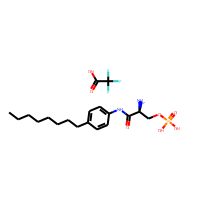
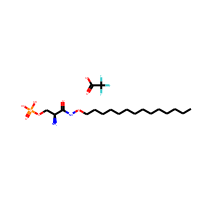
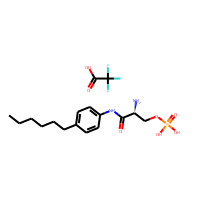
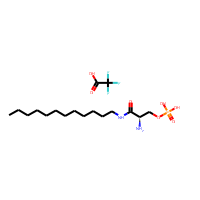
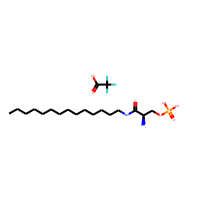

In [3]:
df = pd.read_csv('../data/S1P1_data.csv')
PandasTools.AddMoleculeColumnToFrame(df,smilesCol='canonical_smiles')
df.head()

In [4]:
def groups_to_df(groups,mols,include_core=False,redraw_sidechains=False):
    """ add the molecule to the dataframe 
    """
    cols = ['Mol']+list(groups.keys())
    if redraw_sidechains:
        for k,vl in groups.items():
            if k=='Core':
                continue
            for i,v in enumerate(vl):
                vl[i] = Chem.RemoveHs(v)
                rdDepictor.Compute2DCoords(vl[i])

    
    if not include_core:
        cols.remove('Core')
        del groups['Core']
    groups['Mol'] = mols
    frame = pd.DataFrame(groups,columns=cols)
    PandasTools.ChangeMoleculeRendering(frame)
    return frame

# fake dataset for testing

,smi,ROMol,pchembl_value
0,c25nc3no5.c12cocc1.O3C,,0.388
1,c25nc3no5.c12ccccc1.O3C1CC1,,0.170
2,c25nc3no5.C12CCC1.O3CC,,0.535
3,c25nc3no5.c12ccccc1.O3CC,,0.718
4,c25nc3no5.C12CCC1.O3C(=O)C,,0.082

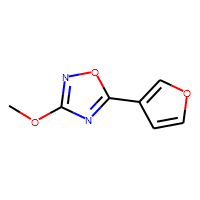
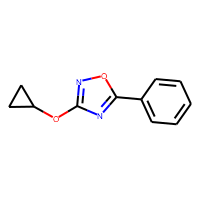
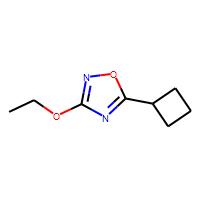
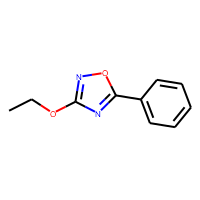
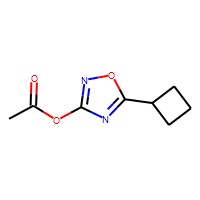

In [5]:
import random
random.seed(0xfeed)
from collections import defaultdict
r1s = ['c12ccccc1','c12cocc1','C12CCC1','C12COC1','c12c[nH]cc1']
r2s = ['O3CC','O3C','O3C1CC1','O3C1CCC1','O3C(=O)C']
core = 'c25nc3no5'
data = defaultdict(list)
while len(data['smi'])<10:
    r1 = r1s[random.randint(0,len(r1s)-1)]
    r2 = r2s[random.randint(0,len(r2s)-1)]
    smi = f"{core}.{r1}.{r2}"
    if smi in data['smi']:
        continue
    data['smi'].append(smi)
    data['ROMol'].append(Chem.MolFromSmiles(smi))
    data['pchembl_value'].append('%.3f'%random.random())
test_df = pd.DataFrame(data)
test_df.head()

# Do the R-group decomposition to get something to work with

,Mol,R1,R2
0,,,
1,,,
2,,,
3,,,
4,,,

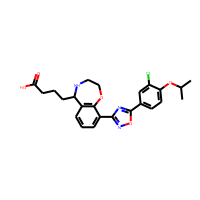
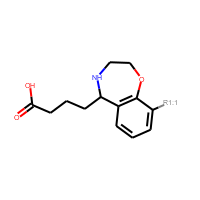
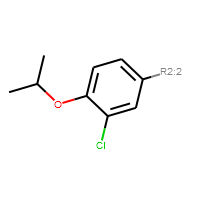
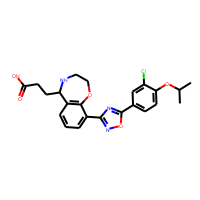
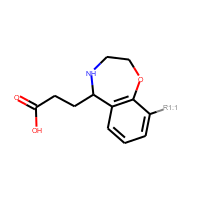
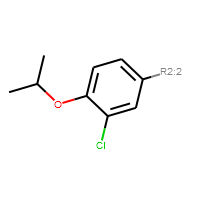
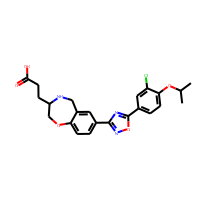
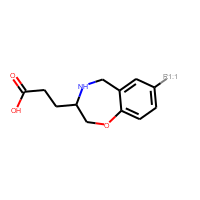
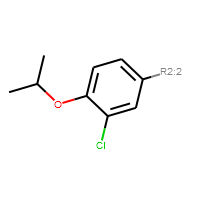
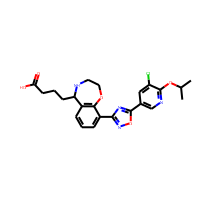
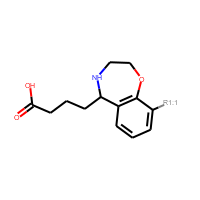
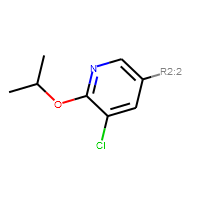
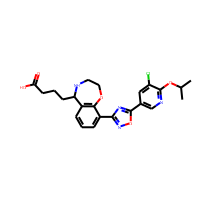
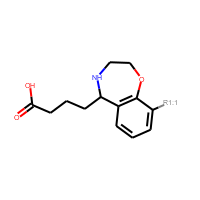
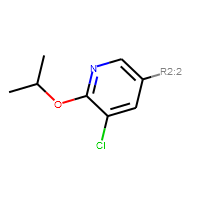

In [11]:
if 1:
    # use real data, provide the scaffold and doc id to use
    doc_scaffold = Chem.MolFromSmarts('[*:1]c1nc([*:2])on1')
    doc_id = 89753
    #doc_id = 99128
    docdf = df[df.doc_id==doc_id]
else:
    # use the testing data
    doc_scaffold = Chem.MolFromSmarts('[*:1]c1nc([*:2])on1')
    docdf = test_df

opts = rdRGroupDecomposition.RGroupDecompositionParameters()
opts.removeHydrogensPostMatch=True
groups,unmatched = rdRGroupDecomposition.RGroupDecompose([doc_scaffold],docdf.ROMol,options=opts,asSmiles=False,asRows=False) 
ms = [y for x,y in enumerate(docdf.ROMol) if x not in unmatched]
res = groups_to_df(groups,ms,include_core=False)
res.head()

For our purposes, it's quicker/easier to get the data from the RGD code in a different format:

In [7]:
groups,unmatched = rdRGroupDecomposition.RGroupDecompose([doc_scaffold],docdf.ROMol,options=opts,asSmiles=True,asRows=False) 

In [12]:
from collections import Counter
from IPython.display import HTML
import base64
def mol_to_img(m):
    dm = Draw.PrepareMolForDrawing(m)
    d2d = Draw.MolDraw2DCairo(250,200)
    dopts = d2d.drawOptions()
    dopts.dummiesAreAttachments=True
    d2d.DrawMolecule(dm)
    d2d.FinishDrawing()
    png_data = d2d.GetDrawingText() 
    png_data = base64.encodebytes(png_data)
    html ='<img src="data:image/png;base64,%s">'%png_data.decode()
    return html

def run_groups(groups,unmatched,mols,values,r1_label='R1',r2_label='R2'):
    # generate SAR matrix
    all_r1s = dict([(y,x) for x,y in enumerate(set(groups[r1_label]))])
    all_r2s = dict([(y,x) for x,y in enumerate(set(groups[r2_label]))])
    labelled_mols = []
    residx = 0
    for i,m in enumerate(mols):
        if i in unmatched:
            continue
        r1_idx = all_r1s[groups[r1_label][residx]]
        r2_idx = all_r2s[groups[r2_label][residx]]
        residx += 1
        labelled_mols.append((i,r1_idx,r2_idx))
    c1 = Counter()
    c2 = Counter()
    for idx,i,j in labelled_mols:
        c1[i] += 1
        c2[j] += 1
    freq1 = [x for x,y in c1.items() if y>=2]
    freq2 = [x for x,y in c2.items() if y>=2]
    reverse_r1s = dict([(y,x) for x,y in all_r1s.items()])
    reverse_r2s = dict([(y,x) for x,y in all_r2s.items()])
    freq_r1s = [reverse_r1s[i] for i in freq1]
    freq_r2s = [reverse_r2s[i] for i in freq2]
    n_r1 = len(freq1)
    n_r2 = len(freq2)
    matrix = [None]*(n_r1*n_r2)
    matrix = np.reshape(matrix,(n_r1,n_r2))
    for idx,i,j in labelled_mols:
        if i not in freq1 or j not in freq2:
            continue
        r1idx = freq1.index(i)
        r2idx = freq2.index(j)
        matrix[r1idx,r2idx] = idx
        
    # now create the html from that
    html = "<table>"
    ths = "".join("<th>%s</th>"%mol_to_img(Chem.MolFromSmiles(x)) for x in freq_r2s)
    html += f"<tr><td></td>{ths}</tr>"
    for i1,x in enumerate(freq_r1s):
        img = mol_to_img(Chem.MolFromSmiles(x))
        row = f"<tr><td>{img}</td>"
        for i2,y in enumerate(freq_r2s):
            if matrix[i1,i2] is not None:
                elem = matrix[i1,i2]
                elem = values.iloc[elem]
            else:
                elem = ''
            row += f"<td>{elem}</td>"    
        row += "</tr>"
        html += row
    html += "</table>"
    return html

In [10]:
html = run_groups(groups,unmatched,docdf.ROMol,docdf.pchembl_value)
HTML(html)